# Explore Double Descent with MNIST

Ref Article:
- https://medium.com/mlearning-ai/double-descent-8f92dfdc442f
- https://evjang.com/2021/10/23/generalization.html

# Use Weight and Bias as Dashboard with pytorch lightning

In [1]:
# Dict for wandb config

CONFIG = {
    # Some Hyperparameter Defination
    "bs": 512,
    "lr": 1e-4,
    "epoch": 2000,
    
    # From Paper
    "noise": 0.2,  # Lable Noise
    "k": 60,  # Model Complexity. Layer specific as [28*28, 1k, 2k, 1k, 10]
}

# wandb run name
NAME = "Conv-CIFAR10-bs{}-lr{}-k{}-noise{}".format(CONFIG['bs'], CONFIG['lr'], CONFIG['k'], CONFIG['noise'])

In [2]:
from pytorch_lightning.loggers import WandbLogger
import wandb

wandb.login()
wandb_logger = WandbLogger(name=NAME, project='test_Double_Descent', config=CONFIG)

wandb: Currently logged in as: feicccccccc (use `wandb login --relogin` to force relogin)


## MNIST dataset

In [3]:
import os
from typing import Optional

import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.nn import functional as F
from torch import nn
from torch.utils.data import DataLoader, random_split

from torchvision.datasets import MNIST, CIFAR10
from torchvision import transforms

import pytorch_lightning as pl
from pytorch_lightning import LightningModule, Trainer
from pytorch_lightning.metrics.functional import accuracy

MNIST.mirrors = [mirror for mirror in MNIST.mirrors
                 if not mirror.startswith("http://yann.lecun.com")]

In [4]:
pl.seed_everything(0)
wandb.login()

Global seed set to 0


True

In [5]:
# pl dataMoudle ref: 
# https://pytorch-lightning.readthedocs.io/en/latest/extensions/datamodules.html

class CIFAR10DataModule(pl.LightningDataModule):
    def __init__(self, data_dir: str = "./data", batch_size: int = 512, noise: float = 0.2):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.noise = noise
        self.num_workers = 16
        
        self.save_hyperparameters()
        
    def prepare_data(self):
        # download
        MNIST(self.data_dir, train=True, download=True)
        MNIST(self.data_dir, train=False, download=True)

    def setup(self, stage: Optional[str] = None):
        self.test_set = CIFAR10(self.data_dir,
                                train=False,
                                transform=transforms.ToTensor(),
                                download=True)
        self.full_data_set = CIFAR10(self.data_dir,
                                     train=True,
                                     transform=transforms.ToTensor(),
                                     download=True)
        
        # Manual fix label shit
        for idx, data in enumerate(self.full_data_set):
            if type(data[1]) == int:
                self.full_data_set.targets[idx] = torch.tensor([data[1]])
        
        self.train_set, self.val_set = random_split(self.full_data_set, [45000, 5000])
        
        # Add noise to training set label
        for i in range(len(self.train_set)):
            idx = self.train_set.indices[i]
            if torch.rand(1) < 0.2:
                self.train_set.dataset.targets[idx] = torch.randint(0, 10, (1,))

    def train_dataloader(self):
        return DataLoader(self.train_set, batch_size=self.batch_size, num_workers=self.num_workers, shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.val_set, batch_size=self.batch_size, num_workers=self.num_workers)

    def test_dataloader(self):
        return DataLoader(self.test_set, batch_size=self.batch_size, num_workers=self.num_workers)
    
    # For inference, used in Trainer.predcit()
    def predict_dataloader(self):
        # TODO: Check what to predict
        return DataLoader(self.test_set, batch_size=64)

In [6]:
dm = CIFAR10DataModule(batch_size=CONFIG['bs'], noise=CONFIG['noise'])
dm.prepare_data()
dm.setup()

Files already downloaded and verified
Files already downloaded and verified


In [7]:
for data in dm.test_set:
    print(data[1])

3
8
8
0
6
6
1
6
3
1
0
9
5
7
9
8
5
7
8
6
7
0
4
9
5
2
4
0
9
6
6
5
4
5
9
2
4
1
9
5
4
6
5
6
0
9
3
9
7
6
9
8
0
3
8
8
7
7
4
6
7
3
6
3
6
2
1
2
3
7
2
6
8
8
0
2
9
3
3
8
8
1
1
7
2
5
2
7
8
9
0
3
8
6
4
6
6
0
0
7
4
5
6
3
1
1
3
6
8
7
4
0
6
2
1
3
0
4
2
7
8
3
1
2
8
0
8
3
5
2
4
1
8
9
1
2
9
7
2
9
6
5
6
3
8
7
6
2
5
2
8
9
6
0
0
5
2
9
5
4
2
1
6
6
8
4
8
4
5
0
9
9
9
8
9
9
3
7
5
0
0
5
2
2
3
8
6
3
4
0
5
8
0
1
7
2
8
8
7
8
5
1
8
7
1
3
0
5
7
9
7
4
5
9
8
0
7
9
8
2
7
6
9
4
3
9
6
4
7
6
5
1
5
8
8
0
4
0
5
5
1
1
8
9
0
3
1
9
2
2
5
3
9
9
4
0
3
0
0
9
8
1
5
7
0
8
2
4
7
0
2
3
6
3
8
5
0
3
4
3
9
0
6
1
0
9
1
0
7
9
1
2
6
9
3
4
6
0
0
6
6
6
3
2
6
1
8
2
1
6
8
6
8
0
4
0
7
7
5
5
3
5
2
3
4
1
7
5
4
6
1
9
3
6
6
9
3
8
0
7
2
6
2
5
8
5
4
6
8
9
9
1
0
2
2
7
3
2
8
0
9
5
8
1
9
4
1
3
8
1
4
7
9
4
2
7
0
7
0
6
6
9
0
9
2
8
7
2
2
5
1
2
6
2
9
6
2
3
0
3
9
8
7
8
8
4
0
1
8
2
7
9
3
6
1
9
0
7
3
7
4
5
0
0
2
9
3
4
0
6
2
5
3
7
3
7
2
5
3
1
1
4
9
9
5
7
5
0
2
2
2
9
7
3
9
4
3
5
4
6
5
6
1
4
3
4
4
3
7
8
3
7
8
0
5
7
6
0
5
4
8
6
8
5
5
9
9
9
5
0
1
0
8
1
1
8
0
2
2
0


5
3
5
7
0
1
2
9
8
1
7
3
5
9
1
9
1
1
3
6
7
4
8
3
5
6
7
0
1
7
7
2
3
3
5
1
7
6
8
4
4
5
7
3
4
7
7
3
6
0
7
2
6
7
4
1
8
0
2
2
1
5
4
0
9
3
4
4
2
3
8
5
0
0
4
6
3
9
2
0
5
7
5
5
1
7
3
1
6
7
9
0
1
2
1
4
6
1
5
9
5
0
4
9
4
9
7
1
6
8
0
6
5
0
8
1
7
5
6
9
3
2
3
9
8
6
1
0
9
0
9
8
7
7
5
2
3
5
5
7
8
7
6
9
1
9
8
6
5
6
7
5
6
7
2
5
9
6
6
7
0
1
0
1
3
2
5
6
1
2
5
1
9
9
8
6
8
6
8
9
0
4
0
3
3
6
4
9
9
7
2
3
5
6
4
6
0
3
7
5
0
2
9
2
7
2
9
2
4
0
6
6
3
4
5
5
9
1
1
4
4
3
5
4
8
0
0
3
9
4
7
4
2
8
3
6
3
1
9
6
3
8
3
8
4
7
5
7
5
3
1
2
6
1
3
2
0
7
5
0
0
0
1
4
3
5
8
4
3
1
7
1
0
4
2
4
1
4
0
1
2
1
7
7
9
8
7
5
4
0
9
0
0
8
2
0
0
2
4
8
6
2
4
6
3
5
1
5
3
7
2
2
9
8
0
0
0
3
4
4
6
1
6
7
4
4
3
9
4
0
8
0
4
6
5
7
9
7
0
5
7
7
3
1
9
3
0
9
5
3
7
9
4
4
1
7
7
1
4
1
2
8
7
0
0
4
7
2
9
7
6
9
3
5
8
0
3
6
8
3
2
4
7
1
1
3
9
7
5
1
0
8
7
0
1
6
9
3
2
7
7
8
1
0
3
4
6
7
5
2
0
1
5
5
1
4
1
3
0
8
6
2
1
3
6
4
1
9
0
4
1
0
1
9
8
6
9
2
4
7
2
2
7
4
9
1
3
2
6
3
4
4
9
4
8
2
6
6
1
6
3
6
5
8
4
6
7
1
9
3
6
7
6
0
7
1
9
5
2
6
7
7
6
5
9
1
5
6
0
2
0
9
1
8
3
5
0
0
0
5


7
5
8
0
8
2
7
0
3
5
3
8
3
5
1
7


## Quick look at the training set

torch.Size([512, 3, 32, 32])
torch.Size([512, 1])
Feature batch shape: torch.Size([512, 3, 32, 32])
Labels batch shape: torch.Size([512, 1])
torch.Size([3, 32, 32])
torch.Size([3, 32, 32])
torch.Size([3, 32, 32])
torch.Size([3, 32, 32])
torch.Size([3, 32, 32])


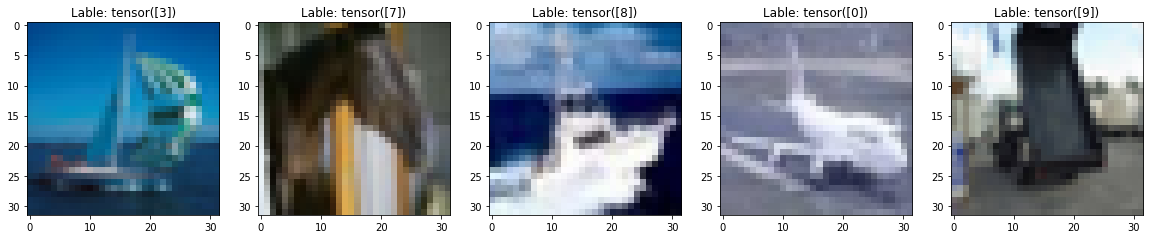

In [8]:
# Display image and label.
train_features, train_labels = next(iter(dm.train_dataloader()))

print(train_features.size())
print(train_labels.size())
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

images=[]

for i in range(0, 5):
    images.append(train_features[i].squeeze())
    print(images[i].shape)

plt.figure(figsize=(20,10))
columns = 5

for i, image in enumerate(images):
    ax = plt.subplot(int(len(images) / columns + 1), columns, i + 1)
    ax.imshow(image.permute(1, 2, 0))
    ax.title.set_text("Lable: {}".format(train_labels[i]))

## Define the model and training step
- Fully connected Network, where number of hidden layer is varing
- Use negative log likelihood loss
- Follow orginial paper using ResNet

In [9]:
# Code from paper
import torch.nn as nn
import torch.nn.functional as F

class PreActBlock(nn.Module):
    '''Pre-activation version of the BasicBlock.'''
    expansion = 1

    def __init__(self, in_planes, planes, stride=1, **kwargs):
        super(PreActBlock, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)

        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False)
            )

    def forward(self, x):
        out = F.relu(self.bn1(x))
        shortcut = self.shortcut(out) if hasattr(self, 'shortcut') else x
        out = self.conv1(out)
        out = self.conv2(F.relu(self.bn2(out)))
        out += shortcut
        return out

class PreActResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10, init_channels=64):
        super(PreActResNet, self).__init__()
        self.in_planes = init_channels
        c = init_channels

        self.conv1 = nn.Conv2d(3, c, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.layer1 = self._make_layer(block, c, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 2*c, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 4*c, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 8*c, num_blocks[3], stride=2)
        self.linear = nn.Linear(8*c*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        # eg: [2, 1, 1, ..., 1]. Only the first one downsamples.
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

def make_resnet18k(k=64, num_classes=10) -> PreActResNet:
    ''' Returns a ResNet18 with width parameter k. (k=64 is standard ResNet18)'''
    return PreActResNet(PreActBlock, [2, 2, 2, 2], num_classes=num_classes, init_channels=k)

In [10]:
class LitModel(LightningModule):
    def __init__(self, k: int, lr: float):
        super().__init__()
        self.model = make_resnet18k(k=k, num_classes=10)
        self.lr = lr
        
        self.save_hyperparameters()

    def forward(self, x):
        x = self.model.forward(x)
        return x
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        return optimizer
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y[:, 0])
        
        metrics = {"loss/train": loss}
        self.log_dict(metrics)
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        val_loss = F.cross_entropy(y_hat, y[:, 0])
        
        metrics = {"loss/val": val_loss}
        self.log_dict(metrics)
        return val_loss
    
    # Only for trainer.test()
    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        test_loss = F.cross_entropy(y_hat, y[:, 0])
        
        metrics = {"loss/test": test_loss}
        self.log_dict(metrics)
        return test_loss

In [11]:
# Define our model and trainer
fc = LitModel(k=CONFIG['k'], lr=CONFIG['lr'])
trainer = pl.Trainer(gpus=1, deterministic=True, max_epochs=CONFIG['epoch'], logger=wandb_logger, log_every_n_steps=1)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [ ]:
trainer.fit(fc, dm)

/home/fei/miniconda3/envs/test_wandb/lib/python3.9/site-packages/pytorch_lightning/core/datamodule.py:423: LightningDeprecationWarning: DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.
  rank_zero_deprecation(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



  | Name  | Type         | Params
---------------------------------------
0 | model | PreActResNet | 9.8 M 
---------------------------------------
9.8 M     Trainable params
0         Non-trainable params
9.8 M     Total params
39.277    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Global seed set to 0


Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [ ]:
trainer.test()